In [1]:
import sys
import os
sys.path.append("..")
from biokey.data import DataInterface
import biokey.tools
import credentials

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [2]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
% matplotlib inline

In [3]:
data = DataInterface(credentials.postgres)

Loading Data
	- Attempting cache load
	- Loaded strokes from cache
Processing Data
	- Attempting cache load
	- Missed dwell and flight cache


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Loading Data', max=15), HTML(value='')))


	- Generating train and test sets


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Generating Sets', max=15), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Generating Sets', max=14), HTML(value='')))


	- Done and cached for later
Done Loading



In [4]:
datasets = data.get_user_sets('1d63b44d-a7cb-4ee6-b228-b0ff5b7d086f')
datasets.train = biokey.tools.filter_keys(datasets.train)
datasets.test = biokey.tools.filter_keys(datasets.test)

# Form Dwell Sequence Frames

In [6]:
length = 440000
seq_length = 20

In [7]:
X_enum = np.array((pd.get_dummies(datasets.train.key_enum).T*datasets.train.dwell).T)
X = X_enum[:length].reshape(int(length/seq_length), seq_length, X_enum.shape[1])
Y = np.array(datasets.train.is_user).astype(np.float32)[:length:seq_length]

In [8]:
X_test_enum = np.array((pd.get_dummies(datasets.test.key_enum).T*datasets.test.dwell).T)
X_test = X_test_enum[:length].reshape(int(length/seq_length), seq_length, X_enum.shape[1])
Y_test = np.array(datasets.test.is_user).astype(np.float32)[:length:seq_length]

# Use Keras

In [10]:
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import TensorBoard
from sklearn.metrics import roc_curve, auc

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [17]:
# Parameters
learning_rate = 0.001
training_epochs = 10
batch_size = 100


# Network Parameters
n_hidden_1 = 256 # 1st layer number of features
n_hidden_2 = 256 # 2nd layer number of features
n_input = X.shape[1] # Number of feature
n_classes = 1 # Number of classes to predict

In [18]:
# create model
model = Sequential()
model.add(LSTM(n_hidden_1, input_shape=(seq_length, X_enum.shape[1]), implementation=2))
model.add(Dropout(0.2))
model.add(Dense(n_classes, activation='sigmoid'))

In [19]:
# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [20]:
# Fit the model
# tbCallBack = TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)
# , callbacks=[tbCallBack]
model.fit(X, Y, epochs=training_epochs, batch_size=batch_size)

Epoch 1/10
22000/22000 [==============================] - 6s 287us/step - loss: 0.5513 - acc: 0.7142
Epoch 2/10
22000/22000 [==============================] - 6s 273us/step - loss: 0.4181 - acc: 0.8049
Epoch 3/10
22000/22000 [==============================] - 6s 272us/step - loss: 0.3442 - acc: 0.8492
Epoch 4/10
22000/22000 [==============================] - 6s 275us/step - loss: 0.2920 - acc: 0.8765
Epoch 5/10
22000/22000 [==============================] - 6s 279us/step - loss: 0.2499 - acc: 0.8964
Epoch 6/10
22000/22000 [==============================] - 6s 279us/step - loss: 0.2158 - acc: 0.9164
Epoch 7/10
22000/22000 [==============================] - 6s 279us/step - loss: 0.1810 - acc: 0.9307
Epoch 8/10
22000/22000 [==============================] - 6s 278us/step - loss: 0.1553 - acc: 0.9407
Epoch 9/10
22000/22000 [==============================] - 6s 275us/step - loss: 0.1334 - acc: 0.9499
Epoch 10/10
22000/22000 [==============================] - 6s 275us/step - loss: 0.1181 - a

In [25]:
def generate_results(y_test, y_score):
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.05])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic curve')
    plt.show()
    print('AUC: %f' % roc_auc)

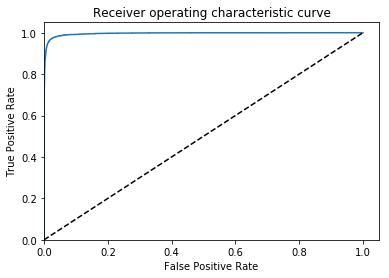

AUC: 0.996269


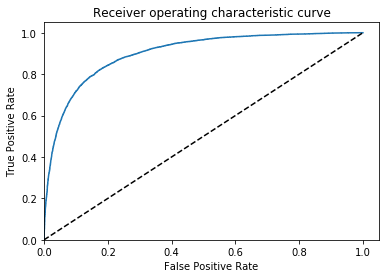

AUC: 0.901078


In [26]:
generate_results(Y, model.predict(X))
generate_results(Y_test, model.predict(X_test))